In [52]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.layers import LeakyReLU, PReLU, ELU, ParametricSoftplus, ThresholdedLinear, ThresholdedReLU, SReLU

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.regularizers import l1, l2, l1l2
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
categories = [
  'good_for_lunch', 
  'good_for_dinner', 
  'takes_reservations', 
  'outdoor_seating',
  'restaurant_is_expensive',
  'has_alcohol',
  'has_table_service',
  'ambience_is_classy',
  'good_for_kids'
]

vgg_cols = ['f' + str(i) for i in range(4096)]

In [3]:
def loss(ytrue, ypred):
  return K.sum( (ytrue - ypred) ** 2 )

# Ensure same train-val split as in previous tests

In [4]:
grouped_data = pd.read_hdf('data/Xtrain_grouped.hdf5')
X_grouped, Y_grouped = grouped_data[vgg_cols], grouped_data[categories]
Xtrain_grouped, Xval_grouped, Ytrain_grouped, Yval_grouped = train_test_split(X_grouped, Y_grouped, test_size=.2, random_state=np.random.RandomState(0))

train_ids = Xtrain_grouped.index # 1386 306 2255 621 1750 ... 1564 2360 3305 1069 1272
val_ids = Xval_grouped.index # 782 2303 1259 2662 1512 ... 3177 688 3616 1435 1075
print train_ids
print val_ids

Int64Index([1386,  306, 2255,  621, 1750, 1024,  925,  472, 2515, 3204,
            ...
            3501, 1975, 2716, 3464, 1422, 1564, 2360, 3305, 1069, 1272],
           dtype='int64', name=u'business_id', length=1596)
Int64Index([ 782, 2303, 1259, 2662, 1512, 3540, 3202, 1317, 3441,   29,
            ...
             567,  100, 3476, 3592, 1327, 3177,  688, 3616, 1435, 1075],
           dtype='int64', name=u'business_id', length=400)


# Load full xtrain data

In [5]:
full_data = pd.read_hdf('data/Xtrain_full_dataframe.ndf5', 'Xtrain')

# Define mapper function

In [66]:
vec = 4096
dim = vec * 1

In [78]:
def get_mapped_data(ids, data):
  X = np.zeros((len(ids), dim)).astype('float16')
  Y = np.zeros((len(ids), 9)).astype('uint8')
  
  for idx, busid in enumerate(ids):
    res = data[data.business_id == busid]

    cols = np.array(res[vgg_cols])
#     X[idx,       : vec]   = cols.mean(axis=0) - cols.std(axis=0)
#     X[idx, vec   : 2*vec] = cols.mean(axis=0)
#     X[idx, 2*vec :      ] = cols.mean(axis=0) + cols.std(axis=0)

    X[idx] = cols.mean(axis=0)# - cols.std(axis=0)
    
    Y[idx] = np.array(res[categories][:1])
    
  return X, Y

In [79]:
Xmapped_train, Ymapped_train = get_mapped_data(train_ids, full_data)
Xmapped_val,   Ymapped_val   = get_mapped_data(val_ids, full_data)
print Xmapped_train.dtype, Ymapped_train.dtype
print Xmapped_train.shape, Ymapped_train.shape

float16 uint8
(1596, 4096) (1596, 9)


# Play with single model

In [80]:
class f1evaluatorCallback(Callback):
  def __init__(self):
    self.bestf1val = 0

  def on_epoch_end(self, epoch, logs={}):
    pred = self.model.predict(Xmapped_train)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_train = f1_score(Ymapped_train, pred, average='micro')
    
    pred = self.model.predict(Xmapped_val)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val = f1_score(Ymapped_val, pred, average='micro')

    if f1_val > self.bestf1val:
      self.bestf1val = f1_val
      print 'Ep %i: train %f, val %f' % (epoch, f1_train, f1_val)

In [81]:
model = Sequential()
np.random.seed(0)

model.add(Dense(100, input_shape=(dim,), activation='softplus'))
model.add(Dropout(.3))

model.add(Dense(9, activation='sigmoid'))
# model.add(Dense(9, input_shape=(dim,), activation='sigmoid'))
model.compile(loss=loss, optimizer='adam')
# model.compile(loss=loss, optimizer=Adam(lr=0.003))

In [82]:
h = model.fit(Xmapped_train, Ymapped_train, verbose=0, callbacks=[f1evaluatorCallback()], nb_epoch=200)

Ep 0: train 0.756202, val 0.755459
Ep 1: train 0.776103, val 0.757156
Ep 2: train 0.811924, val 0.795455
Ep 3: train 0.826002, val 0.803685
Ep 4: train 0.831829, val 0.806057
Ep 6: train 0.842937, val 0.813933
Ep 7: train 0.845077, val 0.817321
Ep 11: train 0.857122, val 0.817780
Ep 13: train 0.860967, val 0.818208
Ep 14: train 0.864080, val 0.823392
Ep 15: train 0.862960, val 0.825810
Ep 18: train 0.873883, val 0.826275
Ep 22: train 0.877681, val 0.830998
Ep 25: train 0.882855, val 0.831228
Ep 28: train 0.885101, val 0.833000
Ep 32: train 0.890376, val 0.833906
Ep 33: train 0.897016, val 0.834380
Ep 47: train 0.910459, val 0.835997
Ep 49: train 0.913047, val 0.836571
Ep 52: train 0.917719, val 0.840260
Ep 188: train 0.977861, val 0.841508


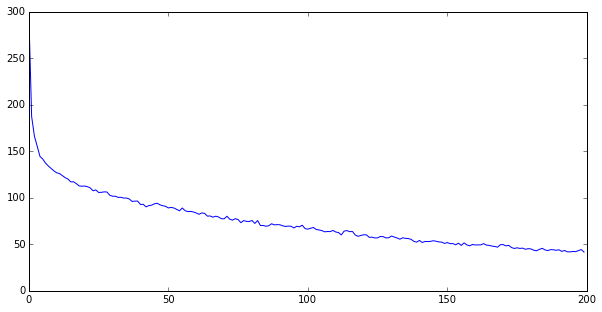

In [83]:
plt.plot(h.epoch, h.history['loss'])

# Train and evaluate ensebmle

In [ ]:
class f1evaluatorCallback(Callback):
  def __init__(self):
    self.bestf1val = 0

  def on_epoch_end(self, epoch, logs={}):
    pred = self.model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val = f1_score(yval, pred, average='micro')

    if f1_val > self.bestf1val:
      self.bestf1val = f1_val
      self.model.save_weights('models/tmp_weights.h5', overwrite=True)

In [19]:
neurons = range(50, 501, 50)
dropout_vals = np.linspace(.1, .5, 5)
print neurons
print dropout_vals

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
[ 0.1  0.2  0.3  0.4  0.5]


In [20]:
def get_model(n_neurons, dropout_val):
  model = Sequential()
  np.random.seed(0)
  
  model.add(Dense(n_neurons, input_shape=(4096,), activation='softplus'))
  model.add(Dropout(dropout_val))

  model.add(Dense(9, activation='sigmoid'))
  model.compile(loss=loss, optimizer='adam')
  
  return model

In [ ]:
models = []

for neu in neurons:
  for dro in dropout_vals:
    print neu, dro,
    model = get_model(neu, dro)
    
    model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=300)
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_last = f1_score(yval, pred, average='micro')
    
    model.load_weights('models/tmp_weights.h5')
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_best = f1_score(yval, pred, average='micro')
    
    print f1_val_last, f1_val_best
    
    models.append((f1_val_best, model))